In [ ]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd    # install octave (a free matlab clone)
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

!apt-get install nvidia-opencl-icd-384        # optional: install nvidia OpenCL(+2min), needed for mmc/mmclab demos
!apt-get install liboctave-dev # liboctave needed to install mmclab octave

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf mcxlab*
#! wget http://mcx.space/nightly/release/v2020/mmclab-linux-x86_64-v2020.zip  # download MCX suite
#! unzip -o mmclab-linux-x86_64-v2020.zip && rm -rf mmclab-linux-x86_64-v2020.zip # unzip MCX suite

# download and install MMC
!git clone https://github.com/fangq/mmc.git

# compile MMC for octave
!make oct -C mmc/src

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
! cp -a $PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex $PWD/MCXStudio/MATLAB/zmat/

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,189 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,556 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main 

In [ ]:
# @title Install iso2mesh for tetrahedral meshing in octave:

# download and unzip iso2mesh
!git clone https://github.com/fangq/iso2mesh.git


Cloning into 'iso2mesh'...
remote: Enumerating objects: 3589, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 3589 (delta 288), reused 490 (delta 237), pack-reused 3035
Receiving objects: 100% (3589/3589), 125.53 MiB | 35.53 MiB/s, done.
Resolving deltas: 100% (2308/2308), done.


In [ ]:
# @title Add paths in octave (same as adding folders in matlab)
%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc

addpath(genpath([pwd filesep 'mmclab']));
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh

In [ ]:
# @title Check installation of different packages in octave
%%octave
% check that mmclab is installed
help mmclab
% check that iso2mesh is installed
help dist2surf

%mmclab('gpuinfo')

In [ ]:
# @title Prepare mesh for slab model of brain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh

% thickness of each layer in mm
TN=[7.25,4.00,2.73,3.29,4.23];

% prepare simulation mesh (a five layered slab):

% prepares a surface-only mesh:
[nodes,faces]=latticegrid([0 200],[0 200],[0 7.25 11.25 13.98 17.27 50]);
[nodes,faces]=latticegrid([0 200],[0 200],[0 TN(1,1) sum(TN(1,1:2)) sum(TN(1,1:3)) sum(TN(1,1:4)) 50]);

% plot the surface mesh to verify it is correct
%plotmesh(nodes, faces);

% prepares interior tetrahedrons for that mesh:
% max_volume is very important and determines our mesh density
% dramatically impacts performance:
max_volume = 100;

[nodes,elems]=surf2mesh(nodes,faces,[],[],1,max_volume,[1 1 4;1 1 9;1 1 12;1 1 14.5;1 1 25]);

% plot the tetrahedral mesh to verify it is correct:
plotmesh(nodes, elems);

% save the mesh values:
save -mat7-binary layered_slab nodes elems;

In [ ]:
# @title Refine Tetrahedron sizes near the source
# this may be necessary when you are plotting near the source or want higher spatial resolution for fluence near the source (or any other feature)
# prevents performance issues from an otherwise large domain

%%octave

addpath(genpath([pwd filesep 'mmc']));                 % add path to mmc
addpath([pwd filesep 'iso2mesh']);                 % add path to iso2mesh


load('layered_slab');
centroids = meshcentroid(nodes, elems(:,1:4));

% set maxvols to a large value by default
% to later set smaller values for specific elements
maxvols = ones(size(elems,1),1)*10000;
% refine the size of tetrahedrons near the source if desired (not necessary in DMMC):
for i=1:size(elems,1)

    % Get elem centroid distance from source
    Dist = norm([centroids(i,:).-[100,100,0]], 2);
    dist(i) = Dist;
    % Refine elements based on distance to source
    if Dist<38
        maxvols(i)=4;
    elseif Dist<20
        maxvols(i)=2;
    end
end

% this command selectively refines (splits into smaller tetrahedrons)
% all the tetrahedrons based on the maxvols sizes.
[new_nodes, new_elems] = meshrefine(nodes, elems, maxvols);

plotmesh(new_nodes, new_elems);
view(-45, -45);

% save new mesh values:
nodes = new_nodes;
elems = new_elems;
save -mat7-binary layered_slab nodes elems;

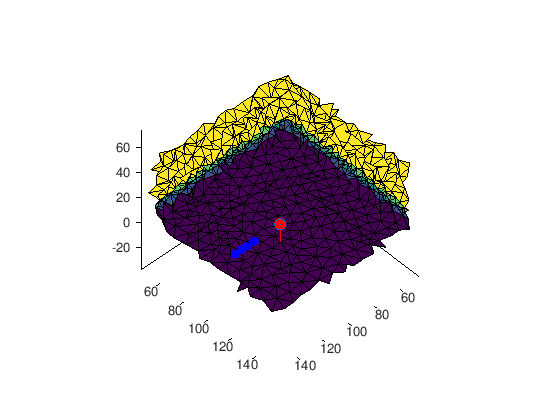

In [ ]:
# @title Prepare MMC simulation config
%%octave

% load the mesh we prepared earlier
load('layered_slab');

% set the config values to the mesh variables
cfg_mmc.node=nodes;
cfg_mmc.elem=elems;

% set the number of photons
nphotons=1e4;
cfg_mmc.nphoton=nphotons;

% set the random seed
cfg_mmc.seed=1234567;

% set the source position and direction:
cfg_mmc.srcpos=[99.5, 100, 0];
cfg_mmc.srcdir=[0, 0, 1];

% we can plot the source position and direction
% to verify it is in the location on the mesh:
figure;
hold on;
plotmesh(nodes, elems, 'x>50 & x<150 & y>50 & y<150');
scatter3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3), 1000, 'MarkerFaceColor', 'r');
quiver3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3),
        cfg_mmc.srcdir(1), cfg_mmc.srcdir(2), cfg_mmc.srcdir(3), 'MaxHeadSize', 10, 'Color', 'r', 'MarkerFaceColor', 'r');

% change view direction to view the mesh from the zero-side of the z-axis:
view(-47, -45);
cfg_mmc.srctype='pencil';

% we set detector positions then plot them to verify positions:
% the following coordinates set detectors at 20, 25, 30, and 35mm away from the source with a radius of 1.5mm
cfg_mmc.detpos=[99.5, 120, 0, 1.5;
                99.5, 125, 0, 1.5;
                99.5, 130, 0, 1.5;
                99.5, 135, 0, 1.5];
scatter3(cfg_mmc.detpos(:,1), cfg_mmc.detpos(:,2), cfg_mmc.detpos(:,3), 500, 'MarkerEdgeColor', 'b', 'MarkerFaceColor', 'b');

% set the time bounds of the simulation in seconds:
cfg_mmc.tstart=0;
cfg_mmc.tend=5e-9;
cfg_mmc.tstep=5e-9;

% set the medium properties:
% labeling,1-air,2-scalp,3-skull,4-csf,5-gray matter,6-white matter
cfg_mmc.prop=[0,0,1,1;
              0.019, 7.8, 0.89, 1.37;
              0.019, 7.8, 0.89, 1.37;
              0.004, 0.009, 0.89, 1.37;
              0.02, 9.0, 0.89, 1.37;
              0.08, 40.9, 0.84, 1.37];

% this sets up a progress bar and timer
cfg_mmc.debuglevel='TP';

% tells the simulation to calculate boundary reflections
cfg_mmc.isreflect=1;

% ray tracing method, elem is typical for mesh-based simulations,
% but 'grid' option will allow faster dual-grid version, at the cost of
% flexibility in discretization of results.
cfg_mmc.method='elem';

% can choose flux or fluence (flux*tstep) as outputs for time gates.
% there is also energy for energy deposition, and several features for fast
% jacobian calculation using our replay method (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6179418/)
cfg_mmc.outputtype='fluence';
cfg_mmc.isreoriented=0;

% picks which gpu to run on, by setting ones or zeros.
% if you had three GPUs and you wanted to use all three, you would do:
% cfg_mmc.gpuid='111';
% if you had three GPUs and wanted to use the last two, you would do:
% cfg_mmc.gpuid='011';

cfg_mmc.gpuid='1';

% save the config file
save -mat7-binary config cfg_mmc



In [ ]:
#@title Run the MMC Slab-brain simulation
%%octave

load config

%% run the simulation
[fluence, detected_photons] = mmclab(cfg_mmc);

%% save the resulting data:
save -mat7-binary sim_data fluence cfg_mmc;


Launching MMCLAB - Mesh-based Monte Carlo for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mmc.nn=15334;

mmc.elem=[87021,4];

mmc.nphoton=10000;

mmc.seed=1234567;

mmc.srcpos=[99.5 100 0];

mmc.srcdir=[0 0 1 0];

mmc.srctype='pencil';

mmc.detnum=4;

mmc.tstart=0;

mmc.tend=5e-09;

mmc.tstep=5e-09;

mmc.prop=5;

mmc.debuglevel='TP';

mmc.isreflect=1;

mmc.method='elem';

mmc.outputtype='fluence';

mmc.gpuid='1';

mmc.ne=87021;

mmc.facenb=[87021,4];

mmc.evol=87021;

mmc.e0=20576;

	done	69

simulating ...

###############################################################################

#                     Mesh-based Monte Carlo (MMC) - OpenCL                   #

#          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          #

#              https://mcx.space/#mmc  &  https://neurojson.io/               #

#                                                                             #

#Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]#

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::      $v2024.2 $Date::                       $ by $Author::             $

###############################################################################

- variant name: [MMC-OpenCL] compiled with OpenCL version [1]

- compiled with: [RNG] xorshift128+ RNG [Seed Length] 4

initializing streams ...	init complete : 0 ms

Building kernel with option: -cl-mad-enable -DMCX_USE_NATIVE -DMCX_SIMPLIFY_BRANCH -DMCX_VECTOR_INDEX -DMCX_SRC_PENCIL   -DUSE_ATOMIC -DMCX_SAVE_DETECTORS -DMCX_DO_REFLECTION -DUSE_BLBADOUEL

build program complete : 1514 ms

- [device 0(1): pthread-Intel(R) Xeon(R) CPU @ 2.20GHz] threadph=78 oddphotons=16 np=10000.0 nthread=128 nblock=64 repetition=1

set kernel arguments complete : 1515 ms 3

lauching mcx_main_loop for time window [0.0ns 5.0ns] ...

simulation run# 1 ...

Progress: [>                                                             ]   0%Progress: [==>                                                           ]   3%Progress: [====>                                                         ]   7%Progress: [=====>                                                        ]   9%Progress: [======>                                                       ]  10%Progress: [========>                                                     ]  14%Progress: [==========>                              

kernel complete:  	5815 ms

retrieving flux ... 	detected 13 photons, total: 13	transfer complete:        5937 ms

normalizing raw data ...	simulated 10000 photons (10000) with 1 devices (ray-tet 25612744)

MCX simulation speed: 2.33 photon/ms

total simulated energy: 10000.00	absorbed: 47.96547%

(loss due to initial specular reflection is excluded in the total)

	done	6872

In [ ]:
#@title Interpolate nodal fluence values to a crosssection of the slab
%%octave

load sim_data
load layered_slab

% distance along the x-axis for the plane containing
% source and detectors
cross_section_srcdist = 99.5;

% define a plane using cross section srcplane:
cutting_plane = [cross_section_srcdist 0 0;cross_section_srcdist 1 0;cross_section_srcdist 0 1];

% vector of y-coorinates for the cross section
% note that our slab is 200mm wide
% if we want to plot fluence values at the center of each 1mm cube,
% we would start at 0.5 and go to 199.5 with 200 steps
cubesize = 1; % cube of 1mm x 1mm x 1mm

y_vals = linspace(0+cubesize/2, 200-cubesize/2, 200);

% vector of z-coordinates for the cross section
% same as y-coordinates but the height of the slab is 50mm
z_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% make a grid of coordinates for all fluence values in the cross section
[yy,zz]=meshgrid(y_vals,z_vals);

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data,cutting_plane);

plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
imagesc(abs(plottable_fluence_data));
[yy_plot,zz_plot]=meshgrid(1:(200),1:(50));
contour(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),'linewidth',5,'linestyle','--','DisplayName','Diffusion');
axis equal;




In [ ]:
#@title Run another MMC Slab-brain simulation with detector as source to form jacobian
%%octave

load config

%% set srcpos to fourth detector position (note we have to specify indices 1 to 3 because the 4th column refers to detector width)
cfg_mmc.srcpos=cfg_mmc.detpos(4,1:3);

% trim off the 4th detector from the list of detectors
cfg_mmc.detpos=cfg_mmc.detpos(1:3,:);

%% run the simulation
[fluence_adj] = mmclab(cfg_mmc);

%% save the resulting data:
save -mat7-binary adjoint_sim fluence_adj;

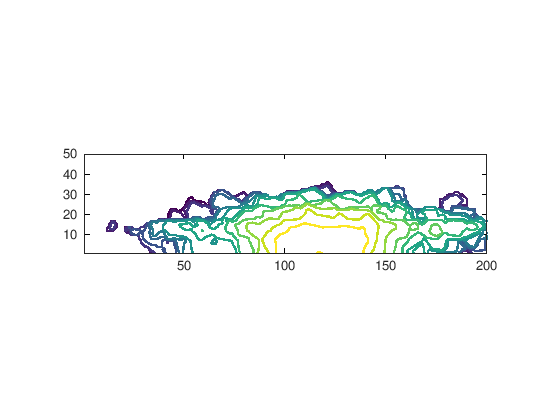

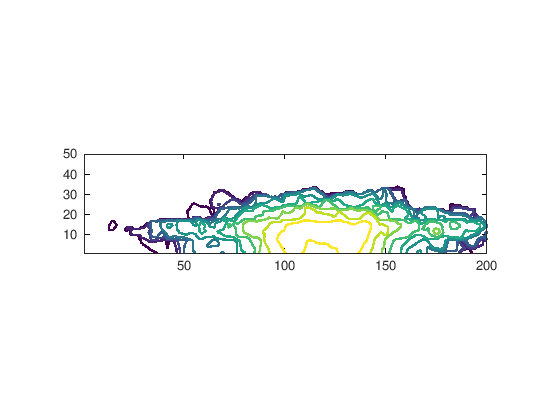

In [ ]:
#@title Produce crosssection of jacobian in the slab
%%octave

load sim_data
load layered_slab
load adjoint_sim

% distance along the x-axis for the plane containing
% source and detectors
cross_section_srcdist = 99.5;

% define a plane using cross section srcplane:
cutting_plane = [cross_section_srcdist 0 0;cross_section_srcdist 1 0;cross_section_srcdist 0 1];

% vector of y-coorinates for the cross section
% note that our slab is 200mm wide
% if we want to plot fluence values at the center of each 1mm cube,
% we would start at 0.5 and go to 199.5 with 200 steps
cubesize = 1; % cube of 1mm x 1mm x 1mm

y_vals = linspace(0+cubesize/2, 200-cubesize/2, 200);

% vector of z-coordinates for the cross section
% same as y-coordinates but the height of the slab is 50mm
z_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% make a grid of coordinates for all fluence values in the cross section
[yy,zz]=meshgrid(y_vals,z_vals);

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data.*fluence_adj.data,cutting_plane);

plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(200),1:(50));
figure;
clines = [-20:1:0];
contour(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),clines, 'linewidth',5,'linestyle','--','DisplayName','Diffusion');
axis equal;

%% we can also re-plot with jacobian values unbiased by node volumes:

%get node volumes
node_volumes = nodevolume(cfg_mmc.node, cfg_mmc.elem);

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data.*fluence_adj.data./node_volumes,cutting_plane);

plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(200),1:(50));
figure;
clines = [-20:1:0];
contour(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),clines, 'linewidth',5,'linestyle','--','DisplayName','Diffusion');
axis equal;


